In [3]:
import argparse
import torch
import numpy as np
import pandas as pd
from PIL import Image
import glob, os, re
from torch.utils.data.dataset import Dataset
from torchvision import transforms
import random
from tqdm import tqdm
import torch.nn.functional as F
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import cv2

import  torchvision.models as models
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
from efficientnet_pytorch import EfficientNet

import import_ipynb
# from models_3ch import MyEffientnet_b1
from clinical_data_loader import ImageDataset 
from clinical_data_loader_external_test import ImageDataset as t_ImageDataset
from clinical_data_loader_external_validation import ImageDataset as v_ImageDataset

importing Jupyter notebook from clinical_data_loader.ipynb
importing Jupyter notebook from clinical_data_loader_external_test.ipynb
importing Jupyter notebook from clinical_data_loader_external_validation.ipynb


In [4]:
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

In [5]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"

In [6]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [7]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

random_seed = 123 #123

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

In [8]:
num_epoch = 10
batch_size = 32


train_transforms = {
    'train_aug' : transforms.Compose([
        transforms.Resize(256),
        transforms.RandomHorizontalFlip(0.5), #0.5
        transforms.RandomVerticalFlip(0.5), #0.5
        transforms.CenterCrop(240),
        transforms.ToTensor(),
    ]),
}

test_transforms={
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(240),
        transforms.ToTensor(),
    ]),
}


In [9]:
img_root = '/home/SMC_data_2101xx_EGFR_deeplearning/EGFR_deep_learning/3ch_img_minmax/img'
label_pth = '/home/SMC_data_2101xx_EGFR_deeplearning/EGFR_deep_learning/3ch_img_minmax/patient_information_clinical.xlsx'

In [25]:
save_root = '/home/SMC_data_2101xx_EGFR_deeplearning/EGFR_deep_learning/3ch_img_minmax/result/test_ver2/img_clinical/external/test'

In [26]:
pth_root = '/home/SMC_data_2101xx_EGFR_deeplearning/EGFR_deep_learning/3ch_img_minmax/result/final_re'

In [27]:
class MyEffientnet_b1_clinical(nn.Module):
    def __init__(self,out_features1, out_features2, out_features3, out_features4, out_features5, out_features6, 
                 out_features7, out_features8, model_name='efficientnet-b1',class_num=45,initfc_type='normal',gain=0.2):
        super(MyEffientnet_b1_clinical, self).__init__()
        
        
        self.clinical_fc1 = nn.Linear(3, out_features5) #(3, 32)
        self.clinical_fc2 = nn.Linear(out_features5, out_features6) #(32, 256)
        self.clinical_fc3 = nn.Linear(out_features6, out_features7) #(256, 1024)
        self.clinical_fc4 = nn.Linear(out_features7, out_features8) #(1024, 1280)

        
        
        model = EfficientNet.from_pretrained(model_name)
        self.model = model
        self.fc1 = nn.Linear(1280 + out_features8, out_features1) #1280
        self.fc2 = nn.Linear(out_features1, out_features2)
        self.fc3 = nn.Linear(out_features2, out_features3)
        self.fc4 = nn.Linear(out_features3, out_features4)
        self.fc5 = nn.Linear(out_features4, 2)
        self.dropout = nn.Dropout(0.5)
        
        self.batchnorm = nn.BatchNorm1d(1280 + out_features8)
        self.batchnorm1 = nn.BatchNorm1d(out_features1)
        self.batchnorm2 = nn.BatchNorm1d(out_features2)
        self.batchnorm3 = nn.BatchNorm1d(out_features3)
        self.batchnorm4 = nn.BatchNorm1d(out_features4)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
        

        
        
        if hasattr(self.fc1, 'bias') and self.fc1.bias is not None:
            nn.init.constant_(self.fc1.bias.data, 0.0)
        if initfc_type == 'normal':
            nn.init.normal_(self.fc1.weight.data, 0.0, gain)
        elif initfc_type == 'xavier':
            nn.init.xavier_normal_(self.fc1.weight.data, gain=gain)
        elif initfc_type == 'kaiming':
            nn.init.kaiming_normal_(self.fc1.weight.data, a=0, mode='fan_in')
        elif initfc_type == 'orthogonal':
            nn.init.orthogonal_(self.fc1.weight.data, gain=gain)


    def forward(self,x, c):
        x = self.model.extract_features(x)
        x = x * torch.sigmoid(x)
        x = nn.functional.adaptive_avg_pool2d(x, 1).squeeze(-1).squeeze(-1)
        
        c = self.clinical_fc1(c)
        c = self.clinical_fc2(c)
        c = self.clinical_fc3(c)
        c = self.clinical_fc4(c)

        x = torch.cat((x, c), 1)
        
        x = self.batchnorm(x)
        x = self.relu(x)
        x = self.fc1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.fc5(x)
        x = F.softmax(x, dim=1)
        return x

In [28]:
t_img_root = '/home/SMC_data_2101xx_EGFR_deeplearning/EGFR_deep_learning/external_validationset/external_test/png'
t_label_pth = '/home/SMC_data_2101xx_EGFR_deeplearning/EGFR_deep_learning/external_validationset/external_test/GGN_TKI_clinical.xlsx'

In [29]:
test_dataset = t_ImageDataset(t_img_root, t_label_pth, 'test', transform = test_transforms['val'])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True,
                                               num_workers=0, pin_memory=True)

In [30]:
my_model = MyEffientnet_b1_clinical(512, 512, 256, 32, 16, 16, 16, 32)
my_model.cuda()

Loaded pretrained weights for efficientnet-b1


MyEffientnet_b1_clinical(
  (clinical_fc1): Linear(in_features=3, out_features=16, bias=True)
  (clinical_fc2): Linear(in_features=16, out_features=16, bias=True)
  (clinical_fc3): Linear(in_features=16, out_features=16, bias=True)
  (clinical_fc4): Linear(in_features=16, out_features=32, bias=True)
  (model): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduc

In [31]:
fname = pth_root + '/classification_checkpoint.pt'
checkpoint = torch.load(fname)
my_model.load_state_dict(checkpoint)

<All keys matched successfully>

In [32]:
class_weight = torch.FloatTensor([0.67, 0.33]).cuda()
criterion = nn.CrossEntropyLoss(class_weight)
optimizer = torch.optim.Adam(my_model.parameters(), lr=1e-4, weight_decay=1e-5) #lr = #1e-4        
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.95 ** epoch) #0.95 

In [33]:
test_acc_check = np.array([])
test_auc_check = np.array([])

test_img = np.array([]).reshape(0, 3, 240, 240)
test_clinic = np.array([]).reshape(0, 3)
test_p_number = np.array([])

In [34]:
with torch.no_grad():
    epoch_loss_test = 0.0
    epoch_acc_test = 0.0
    predicted_test_output = np.array([])
    test_real = np.array([])
    test_probability = np.array([]).reshape(0, 2)

    my_model.eval()

    for enu, (test_x_batch, test_y_batch, test_clinical_batch, p_number) in enumerate(tqdm(test_loader)):
        test_x = Variable(test_x_batch).cuda()
        test_y = Variable(test_y_batch).cuda()
        test_clinical = Variable(test_clinical_batch).cuda()

        test_output = my_model(test_x, test_clinical)
        test_epoch_loss = criterion(test_output, torch.max(test_y, 1)[1])

        epoch_loss_test += (test_epoch_loss.data.item() * len(test_x_batch))

        pred_test = np.argmax(test_output.data.cpu().numpy(), axis = 1)
        true_test = np.argmax(test_y.data.cpu().numpy(), axis = 1)
        predicted_test_output = np.append(predicted_test_output, pred_test)
        test_real = np.append(test_real, true_test)
        test_probability = np.append(test_probability, test_output.detach().data.cpu().numpy(), axis = 0)
        test_img = np.append(test_img, test_x_batch.detach().data.cpu().numpy(), axis = 0)
        test_clinic = np.append(test_clinic, test_clinical.detach().data.cpu().numpy(), axis = 0)
        test_p_number = np.append(test_p_number, p_number)


    del test_x_batch, test_y_batch, test_output
    test_loss = epoch_loss_test / len(test_dataset)
    test_acc = len(np.where(predicted_test_output == test_real)[0]) / len(predicted_test_output)
    test_auc_score = roc_auc_score(test_real, test_probability[:, 1])
    test_auc_check = np.append(test_auc_check, test_auc_score)
    test_acc_check = np.append(test_acc_check, test_acc)


print('train auc: {:.2f} '
     'acc: {:.2f}\t '
      .format(test_auc_score, test_acc))

100%|██████████| 3/3 [00:01<00:00,  2.73it/s]

train auc: 0.75 acc: 0.76	 


In [35]:
test_real = test_real.reshape(83, 1)
predicted_test_output = predicted_test_output.reshape(83, 1)

In [36]:
test_label_output = np.append(test_real, predicted_test_output, axis = 1)

In [37]:
test_label_output_pd = pd.DataFrame(test_label_output, columns = ['real label', 'predicted label'])

In [38]:
test_label_output_pd.to_csv(save_root + '/deep_learning_output_test.csv', index = False)

In [39]:
conf_matrix = confusion_matrix(test_real, predicted_test_output)

In [40]:
sensitivity = conf_matrix[0, 0] / conf_matrix.sum(axis = 1)[0]
specificity = conf_matrix[1, 1] / conf_matrix.sum(axis = 1)[1]

In [41]:
print('sensitivity : ', sensitivity)
print('specificity : ', specificity)

sensitivity :  0.6
specificity :  0.7692307692307693


In [42]:
fpr, tpr, threshold = roc_curve(test_real.reshape(83, ), test_probability[:, 0], pos_label = 0)

In [43]:
auc_score = roc_auc_score(test_real.reshape(83, ), test_probability[:, 1])

In [44]:
auc_score

0.7487179487179487

In [45]:
df_prob = pd.DataFrame(test_probability, columns = ['label_0', 'label_1'])

In [46]:
df_prob.to_csv(save_root + '/deep_learning_prob_test.csv', index = False)

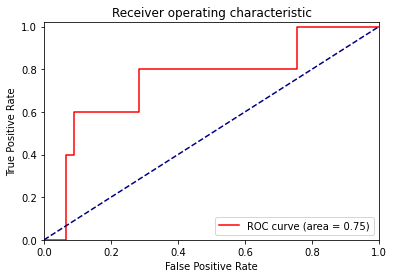

In [47]:
plt.plot(fpr,tpr, color = 'red', label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc=4)
fig = plt.gcf()
fig.savefig(save_root + '/roc_curve.png', dpi = fig.dpi)
plt.show()